In [31]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from cfl.visualization.basic_visualizations import visualize_macrostates
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [32]:
file = 'data/10km_data.csv'

data = pd.read_csv(file)
Xraw = np.array(data[['lat', 'long']])
Yraw = np.array(data['generated_temp']).reshape(-1,1)
print(Xraw.shape, Yraw.shape)

(12700, 2) (12700, 1)


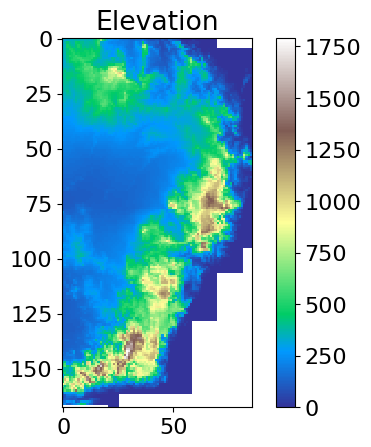

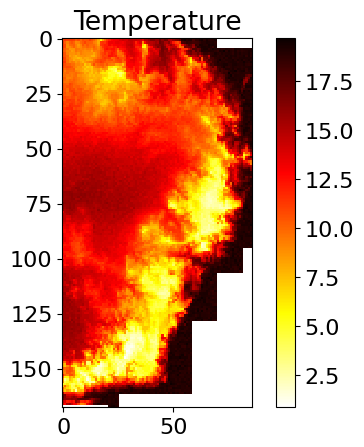

In [33]:
# PLOT TEMP AND ELEVATION FOR RAW DATAFRAME

alt_grid, temp_grid = get_alt_temp_grids(data)

plt.figure(1)
plt.imshow(alt_grid, cmap='terrain', interpolation='nearest')
plt.colorbar()
plt.title('Elevation')
plt.show()

plt.figure(2)
plt.imshow(temp_grid, cmap='hot_r', interpolation='nearest')
plt.colorbar()
plt.title('Temperature')
plt.show()

In [34]:
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

In [35]:
# Create 3 dictionaries: one for data info, one with CDE parameters, and one with cluster parameters

# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not
# allowed for data_info)
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 2000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 1,
                    'show_plot'   : True,
                }
}

# cluster_params consists of specifying two clustering objects
# CFL automatically recognizes the names of all sklearn.cluster models as keywords
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 100},
                         'verbose' : 0
}
# no longer need effect clustering
'''effect_cluster_params = {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 100},
                         'verbose' : 0
}'''

"effect_cluster_params = {'model' : 'KMeans',\n                         'model_params' : {'n_clusters' : 100},\n                         'verbose' : 0\n}"

In [36]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params]

results_path = 'sample_run' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

All results from this run will be saved to sample_run/experiment0003
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/2000
149/149 [==============================] - 1s 3ms/step - loss: 0.9858 - val_loss: 0.9988
Epoch 2/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9566 - val_loss: 0.9761
Epoch 3/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9385 - val_loss: 0.9605
Epoch 4/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9243 - val_loss: 0.9470
Epoch 5/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9107 - val_loss: 0.9336
Epoch 6/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.8977 - val_loss: 0.9211
Epoch 7/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.8854 - val_loss: 0.9090
Epoch 8/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.8735 - val_loss: 0.8973
Epoch 9/2000
149/149 [==================

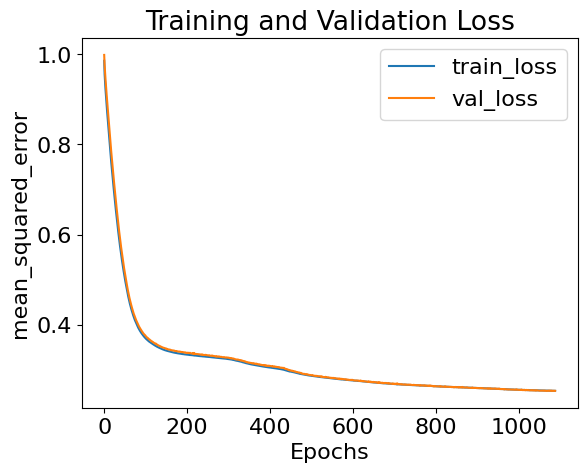

397/397 [==============================] - 0s 690us/step
Loading parameters from  tmp_checkpoints20012025160928/best_weights
Saving parameters to  sample_run/experiment0003/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [37]:
results = my_exp.train()

# Reconstruct the elevation map based on labels

# LOOK IN DATA, POINTS ARE GROUPED BY LAT

# does ylbls even matter?

In [38]:
xlbls = results['CauseClusterer']['x_lbls']
# ylbls = results['EffectClusterer']['y_lbls']

print(xlbls[:10], xlbls[-5:])
# print(ylbls[:10], ylbls[-5:])

[85 85 62 23 23 66 35 91 77 70] [67  2 60 20 38]


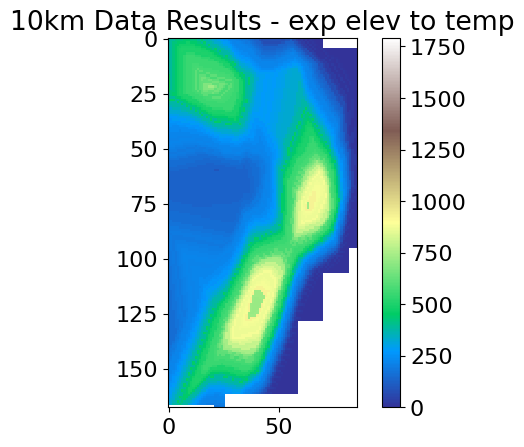

In [39]:
reconstruct_alts = reconstruct_groups(data, xlbls, title='10km Data Results - exp elev to temp')

# for 25km, used 50 clusters, for 10km, used 100 clusters

# WANT TO CLASSIFY ACCURACY

mean absolute error: 92.78099057541303


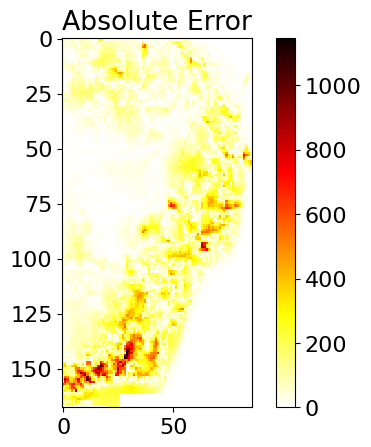

mean squared error: 23017.063422755924


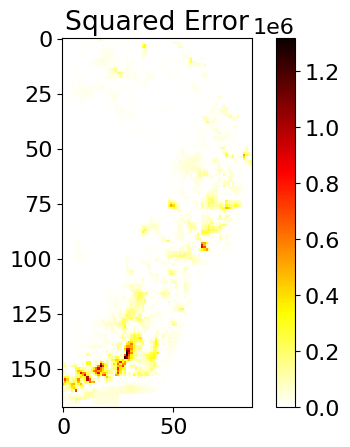

In [40]:
print(f'mean absolute error: {err(alt_grid, reconstruct_alts, "mean_abs")}')
plot_err(alt_grid, reconstruct_alts, 'abs')

print(f'mean squared error: {err(alt_grid, reconstruct_alts, "mean_squared")}')
plot_err(alt_grid, reconstruct_alts, 'squared')

For linear models, mean abs error around 105, mean squared around 25000

# Why does clustering always miss the southernmost peaks?